In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import copy

In [2]:
#Loading the Yahoo stocks data
yahoo_data = pd.read_csv('yahoo_data.csv', parse_dates=['Date'], infer_datetime_format="%b %d, %Y",
                         index_col = [0]).interpolate() #We use interpolation to linearly fill missing data

#Loading the data for modelling and 
model_data = pd.read_csv('model_data.csv', parse_dates=['Unnamed: 0'], infer_datetime_format="%Y-%m-%d",
                         index_col = [0]).interpolate() 
model_data.index.name = 'Date'                      #Set index name to match with Yahoo data
model_data.index = pd.to_datetime(model_data.index) #Convert the index to datetime type object

model_data.head()


,AMD,GOOGL,MSFT,PSA,BLL,TSLA,AMZN,AAPL,NDAQ,DOW,...,IFF,WEC,XYL,SLG,NWL,RMD,VTR,ROST,NRG,LNC
Date,,,,,,,,,,,,,,,,,,,,,
2021-03-17,0.0,1.0,1.0,9.0,8.0,3.0,6.0,3.0,5.0,5.0,...,9.0,6.0,5.0,2.0,5.0,3.0,9.0,0.0,3.0,4.0
2021-03-18,9.0,2.0,5.0,6.0,4.0,8.0,7.0,5.0,8.0,8.0,...,9.0,4.0,4.0,9.0,0.0,5.0,7.0,9.0,0.0,4.0
2021-03-19,6.0,1.0,0.0,4.0,4.0,7.0,8.0,1.0,2.0,1.0,...,2.0,2.0,8.0,9.0,2.0,5.0,9.0,1.0,5.0,3.0
2021-03-20,3.0,2.0,3.0,4.0,8.0,3.0,6.0,3.0,3.0,6.0,...,9.0,1.0,2.0,6.0,3.0,2.0,0.0,4.0,0.0,5.0
2021-03-21,9.0,5.0,8.0,9.0,9.0,4.0,5.0,2.0,9.0,0.0,...,4.0,4.0,9.0,5.0,8.0,0.0,0.0,9.0,9.0,9.0


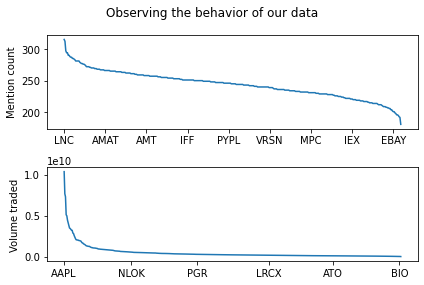

In [3]:
mention_count = model_data.sum(axis = 0).sort_values(ascending = False) #Number of total mentions for each stock
volume_traded = yahoo_data.sum(axis = 0).sort_values(ascending = False) #Amount of volume traded for each stock

#Plotting the mention count and volume traded for all stocks into simple graphs

fig, (ax1, ax2) = plt.subplots(2,1)
fig.suptitle('Observing the behavior of our data')

ax1.plot(mention_count)
ax1.set_xticks(['LNC','AMAT','AMT','IFF','PYPL','VRSN','MPC','IEX','EBAY'])
ax1.set_ylabel('Mention count')


ax2.plot(volume_traded)
ax2.set_xticks(['AAPL', 'NLOK', 'PGR', 'LRCX', 'ATO', 'BIO'])
ax2.set_ylabel('Volume traded')

fig.tight_layout()
plt.show()

In [4]:
class Stock_analyzer:
    #We want to calculate daily percentage change in volume/mentions for a specific stock.
    #However, some stocks get 0 mentions on several days, rendering the percentage change infinity on the next day.
    #We replace this value with NaN and interpolate to get a continuous graph.
    
    def __init__(self, stock_name):
        self.stock_name = stock_name
        self.mtn = model_data[self.stock_name].pct_change().replace(np.inf,np.nan).interpolate() #Extract mention count
        self.vol = yahoo_data[self.stock_name].pct_change().replace(np.inf,np.nan).interpolate() #Extract volume traded
        self.data = pd.concat([self.mtn, self.vol], axis = 1, join = 'inner', keys = ['Mentions', 'Volume']) #Join these two
    
    #Get the differences in mention/volume for each day (as a list)
    def get_differenced_data(self):
        data_diff = copy.deepcopy(self.data) 
        data_diff = data_diff.diff()
        return data_diff
        
    #Transfer the values into positive change, negative change or no change (make use of instancing)
    def get_directed_data(self):
        data_diff = self.get_differenced_data()
        
        directed_data = copy.deepcopy(data_diff) #Creating a new list to insert the directed data into

        #Iterate over columns and rows
        for x in directed_data: 
            for i in range(0,len(directed_data[x])):
                if directed_data[x][i] > 0:
                    directed_data[x][i] = 1
                elif directed_data[x][i] < 0:
                    directed_data[x][i] = -1
                else:
                    directed_data[x][i] = 0
        return directed_data

    #Observe the correlation in the tendencies of the two measures (on the same day)
    def get_correlation(self):
        directed_data = self.get_directed_data()
        
        test_corr = np.corrcoef(directed_data['Mentions'], directed_data['Volume'])
        return test_corr

    #Count the percentage of instances where the trend is the same
    def get_incidence(self):
        directed_data = self.get_directed_data()
        incidence = directed_data['Mentions'] == directed_data['Volume']
        inc_rate = (incidence.sum()/len(incidence)).round(4)
        #inc_rate = "{:.2%}".format(inc_rate) #Converting to a percentage
        return inc_rate
    
    #Get incidence with time lag - 
        #offset allows to shifts the values to right with the use of the specified integer
    def get_incidence_offset(self, offset_mentions = 0, offset_volume = 0):
        directed_data = self.get_directed_data()
        
        incidence = []
        for r in range(0,directed_data.shape[0]):
            try:
                incidence.append(directed_data['Mentions'][r + offset_mentions] == directed_data['Volume'][r + offset_volume])
            except IndexError:
                pass
        incidence = pd.Series(incidence)    
        inc_offset = (incidence.sum()/len(incidence)).round(4)
        return inc_offset

In [5]:
#Calculate the differences between days
S = Stock_analyzer('AAPL')

S.get_correlation()
S.get_incidence()

0.4054

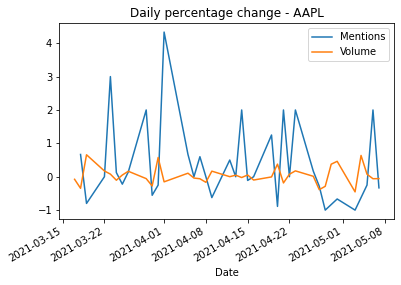

In [6]:
#Plot the result
S.data['Mentions'].plot()
S.data['Volume'].plot()

plt.title(f'Daily percentage change - ' + S.stock_name)
plt.legend()
plt.show()

In [7]:
#Get incidence list
tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
acro = tickers[0]['Symbol'].tolist()             #creating a list of tickers
acro = [a.replace('.', '-') for a in acro]

def get_incidences(acro, offset_volume_by = None):
    incidence_df = pd.DataFrame({'Stock': pd.Series([], dtype='str'),
                                'Incidence': pd.Series([], dtype='int'),
                                f'Incidence offset by': pd.Series([], dtype='float')})
    for a in acro:
        try: 
            stock_name = Stock_analyzer(a).stock_name
            incidence = Stock_analyzer(a).get_incidence()
            incidence_3 = Stock_analyzer(a).get_incidence_offset(offset_mentions = 3)
            new_row = pd.DataFrame({'Stock': pd.Series([stock_name]),
                                    'Incidence': pd.Series([incidence]),
                                    f'Incidence offset by': pd.Series([incidence_3], dtype='float')})
            incidence_df = incidence_df.append(new_row)
        #To be handled
        except KeyError:
            pass
        except TypeError:
            pass
    return incidence_df

incidence_df = get_incidences(acro)

In [8]:
no_offset = incidence_df['Incidence'].sum()
offset_3 = incidence_df['Incidence offset by'].sum()
print(no_offset, offset_3)

196.163 190.26510000000002
